
# 01 – Vue d'ensemble du projet et données

Ce notebook présente la **structure générale** du projet, charge les données de base
et donne quelques statistiques descriptives.  
Il sert de point d'entrée pour comprendre rapidement ce que contient le dépôt.

**Objectifs :**
- comprendre l'architecture (`src/models`, `src/pricing`, `src/calibration`, `src/risk`, `notebooks`, etc.) ;
- explorer les données disponibles dans `data/` ;
- visualiser quelques séries temporelles et distributions de rendements.


In [1]:

import os
import pathlib
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# On suppose que ce notebook se trouve dans le dossier "notebooks"
NOTEBOOK_DIR = pathlib.Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

print("Notebook dir :", NOTEBOOK_DIR)
print("Project root :", PROJECT_ROOT)

# Pour pouvoir faire `import src.xxx`
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "src"))


Notebook dir : /home/hugo/Bureau/Github/BasicQuantitativeAlgorithms/notebooks
Project root : /home/hugo/Bureau/Github/BasicQuantitativeAlgorithms



## 1. Architecture du projet

On liste récursivement les principaux répertoires pour avoir une vue d'ensemble.


In [2]:

for root, dirs, files in os.walk(PROJECT_ROOT):
    dirs[:] = [d for d in dirs if d not in {'.git', '.pytest_cache', '__pycache__', '.idea'}]
    rel_root = pathlib.Path(root).relative_to(PROJECT_ROOT)
    indent = "  " * (len(rel_root.parts))
    print(f"{indent}{rel_root}/")
    for f in files:
        print(f"{indent}  - {f}")


./
  - requirements.txt
  - setup.cfg
  - .gitignore
  - README.md
  notebooks/
    - 03_pricing_comparison.ipynb
    - 01_overview_and_data.ipynb
    - 04_calibration_and_risk.ipynb
    - 02_models_simulation.ipynb
  src/
    - simulation.py
    - __init__.py
    - stats.py
    - plotting.py
    - utils.py
    src/models/
      - __init__.py
      - heston.py
      - base_model.py
      - variance_gamma.py
      - gbm.py
    src/pricing/
      - monte_carlo.py
      - black_scholes.py
      - greeks.py
      - pde_solver.py
    src/calibration/
      - likelihood.py
      - optimization.py
      - moments.py
    src/risk/
      - var.py
  tests/
    - test_stats.py
  data/
    - .~lock.market_data.csv#



## 2. Chargement des données

On parcourt le dossier `data/` et on charge quelques fichiers (CSV, Parquet, etc.)
pour inspecter rapidement les séries temporelles disponibles.


In [4]:
# --- CELLULE MISE À JOUR POUR CRÉER UN CSV PROPRE ---
import os
import sys
import pandas as pd

# 1. Installation automatique de yfinance si absent
try:
    import yfinance as yf
except ImportError:
    print("Installation de yfinance...")
    !{sys.executable} -m pip install yfinance
    import yfinance as yf

# Configuration (assumant que PROJECT_ROOT est déjà défini)
TICKER = "AAPL" 
START_DATE = "2020-01-01"
END_DATE = "2023-01-01"

try:
    # Tente d'utiliser PROJECT_ROOT de la cellule précédente
    data_dir = os.path.join(PROJECT_ROOT, "data")
except NameError:
    # Fallback si l'utilisateur exécute cette cellule seule
    data_dir = "data" 
    
FILENAME = "market_data_clean.csv" # Nouveau nom pour éviter le conflit
FILE_PATH = os.path.join(data_dir, FILENAME)

# 1. Setup folder
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# 2. Téléchargement et sauvegarde si le fichier n'existe pas déjà
if not os.path.exists(FILE_PATH):
    print(f"Téléchargement et formatage des données pour {TICKER}...")
    df_market = yf.download(TICKER, start=START_DATE, end=END_DATE)
    
    # --- MODIFICATIONS CLÉS POUR UN CSV ROBUSTE ---
    # 3. Ne garder que l'indice (Date) et la colonne Close
    df_clean = df_market[['Close']].copy() 

    # 4. Renommer la colonne en 'Price' pour la compatibilité avec le notebook
    df_clean.rename(columns={'Close': 'Price'}, inplace=True)   
    # 5. Réinitialiser l'index pour que la date devienne une colonne normale nommée 'Date'
    df_clean.reset_index(inplace=True)
    
    # 6. Sauvegarder le CSV propre sans index Pandas
    df_clean.to_csv(FILE_PATH, index=False) 
    
    print(f"Succès ! Fichier propre sauvegardé ici : {FILE_PATH}")
    print(f"Le fichier contient les colonnes : {list(df_clean.columns)}")
else:
    print(f"Le fichier de données existe déjà : {FILE_PATH}.")

/tmp/ipykernel_33698/3092193889.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_market = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Téléchargement et formatage des données pour AAPL...
Succès ! Fichier propre sauvegardé ici : /home/hugo/Bureau/Github/BasicQuantitativeAlgorithms/data/market_data_clean.csv
Le fichier contient les colonnes : [('Date', ''), ('Price', 'AAPL')]


In [5]:

sample_csv = None
data_dir = PROJECT_ROOT / "data"
for p in sorted(data_dir.glob("**/*.csv")):
    sample_csv = p
    break

if sample_csv is not None:
    print("Chargement de :", sample_csv)
    df = pd.read_csv(sample_csv, index_col='Date', parse_dates=True)    
    display(df.head())
    print(df.describe(include='all'))
else:
    print("Aucun CSV trouvé dans data/. Adapter ce bloc selon vos données.")


Chargement de : /home/hugo/Bureau/Github/BasicQuantitativeAlgorithms/data/market_data_clean.csv


,Price
Date,
NaT,AAPL
2020-01-02,72.46826934814453
2020-01-03,71.76371765136719
2020-01-06,72.3355712890625
2020-01-07,71.99535369873047


                    Price
count                 757
unique                748
top     118.5470199584961
freq                    2



## 3. Rendements et statistiques de base

À partir d'une série de prix $P_t$, on calcule les **rendements logarithmiques**
$$ R_t = \log P_t - \log P_{t-1}. $$


In [6]:
if 'df' in globals():
    price_col_candidates = [c for c in df.columns if c.lower() in ('close', 'price', 'adj_close')]
    
    if price_col_candidates:
        price_col = price_col_candidates[0]
        
        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
        
        df.dropna(subset=[price_col], inplace=True)
        
        prices = df[price_col].values
        log_returns = np.diff(np.log(prices))
        
        print("Nombre de rendements :", len(log_returns))
        print("Moyenne :", np.mean(log_returns))
        print("Volatilité (std) :", np.std(log_returns))
    else:
        print("Impossible de trouver une colonne de prix évidente dans df.")

Nombre de rendements : 755
Moyenne : 0.0007534747223390814
Volatilité (std) : 0.023239828303422173


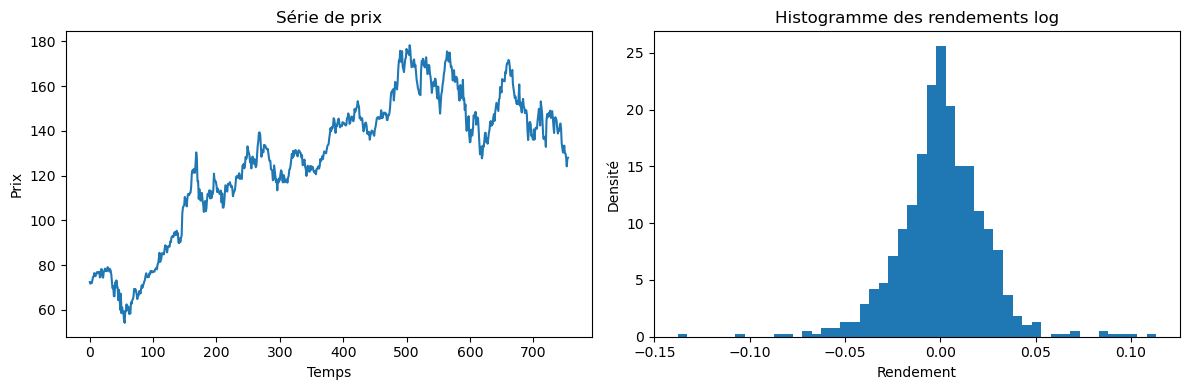

In [7]:

if 'log_returns' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(prices)
    axes[0].set_title("Série de prix")
    axes[0].set_xlabel("Temps")
    axes[0].set_ylabel("Prix")

    axes[1].hist(log_returns, bins=50, density=True)
    axes[1].set_title("Histogramme des rendements log")
    axes[1].set_xlabel("Rendement")
    axes[1].set_ylabel("Densité")

    plt.tight_layout()
    plt.show()



## 4. Points d'analyse possibles

- Comparer les distributions de rendements sur différentes fenêtres temporelles.
- Étudier la présence d'asymétrie / leptokurtose (moments d'ordre supérieur).
- Mettre en regard ces statistiques empiriques avec celles prédites par les modèles (GBM, Heston, Variance Gamma) dans les autres notebooks.
